# Appendix: helper functions

In [1]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display

Here we create some helper functions that will be used across notebooks using the magic `%%writefile`.

## Metrics

In [2]:
%%writefile ../ml4pmt/metrics.py
import numpy as np


def test_monthly(df):
    return int(len(df) / len(df.asfreq("M"))) == 1


def test_bday(df):
    return int(len(df) / len(df.asfreq("B"))) == 1


def test_day(df):
    return int(len(df) / len(df.asfreq("D"))) == 1


def sharpe_ratio(df, num_period_per_year=None):
    num_period_per_year = None
    if test_monthly(df):
        num_period_per_year = 12
    if test_bday(df):
        num_period_per_year = 260
    if test_day(df):
        num_period_per_year = 365
    if num_period_per_year is None:
        return np.nan
    else:
        return df.mean() / df.std() * np.sqrt(num_period_per_year)


def drawdown(x, return_in_risk_unit=True, window=36, num_period_per_year=12):
    dd = x.cumsum().sub(x.cumsum().cummax())
    if return_in_risk_unit:
        return dd.div(x.rolling(window).std().mul(np.sqrt(num_period_per_year)))
    else:
        return dd

Overwriting ../ml4pmt/metrics.py


## Data visualisation

Data exploration, in particular based on visualisation, is crucial to modern data science. `Pandas` has a lot of plotting functionalities (e.g. see the graph below), but we will find it usefull to use a custom `plot` set of functions.

In [3]:
%%writefile ../ml4pmt/plot.py
from ml4pmt.metrics import sharpe_ratio
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


plt.style.use("seaborn-whitegrid")


def line(
    df,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    cumsum=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    legend_sharpe_ratio=None,
    legend=True,
    yscale=None,
    start_date=None,
):
    if loc == "best":
        bbox_to_anchor = None
    if isinstance(df, dict):
        df = pd.concat(df, axis=1)
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if start_date is not None:
        df = df[start_date:]
    if cumsum & (legend_sharpe_ratio is None):
        legend_sharpe_ratio = True
    if legend_sharpe_ratio:
        df.columns = [
            f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]
    if cumsum:
        df = df.cumsum()
    if sort:
        df = df.loc[:, lambda x: x.iloc[-1].sort_values(ascending=False).index]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(df.index, df.values)
    if legend:
        ax.legend(df.columns, loc=loc, bbox_to_anchor=bbox_to_anchor)
    ax.set_title(title)
    if yscale == "log":
        ax.set_yscale("log")


def bar(
    df,
    err=None,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    horizontal=False,
    baseline=None,
    rotation=0,
):
    if isinstance(df, pd.DataFrame):
        df = df.squeeze()
    if isinstance(df, dict):
        df = pd.Series(df)
    if sort:
        df = df.sort_values()
    if err is not None:
        err = err.loc[df.index]
    labels = df.index
    x = np.arange(len(labels))
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if horizontal:
        ax.barh(x, df.values, xerr=err, capsize=5)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.barh(x, df_.values, color="lightgreen")
    else:
        ax.bar(x, df.values, yerr=err, capsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.bar(x, df_.values, color="lightgreen")
    ax.set_title(title)


def heatmap(
    df,
    ax=None,
    figsize=(8, 5),
    title="",
    vmin=None,
    vmax=None,
    vcompute=True,
    cmap="RdBu",
):
    labels_x = df.index
    x = np.arange(len(labels_x))
    labels_y = df.columns
    y = np.arange(len(labels_y))
    if vcompute:
        vmax = df.abs().max().max()
        vmin = -vmax
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    pos = ax.imshow(
        df.T.values, cmap=cmap, interpolation="nearest", vmax=vmax, vmin=vmin
    )
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(labels_x, rotation=90)
    ax.set_yticklabels(labels_y)
    ax.set_title(title)
    ax.grid(True)
    fig.colorbar(pos, ax=ax)


def scatter(
    df,
    xscale=None,
    yscale=None,
    xlabel=None,
    ylabel=None,
    xticks=None,
    yticks=None,
    figsize=(8, 5),
    title=None,
):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.scatter(df, df.index, facecolors="none", edgecolors="b", s=50)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xscale is not None:
        ax.set_xscale(xscale)
    if yscale is not None:
        ax.set_yscale(yscale)
    if yticks is not None:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    ax.set_title(title)

Overwriting ../ml4pmt/plot.py


In [4]:
from ml4pmt.plot import bar, line, heatmap

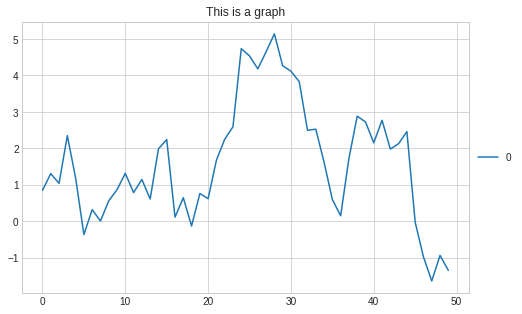

In [5]:
line(pd.Series(np.random.normal(size=50)), cumsum=True, title="This is a graph", 
     legend_sharpe_ratio=False)

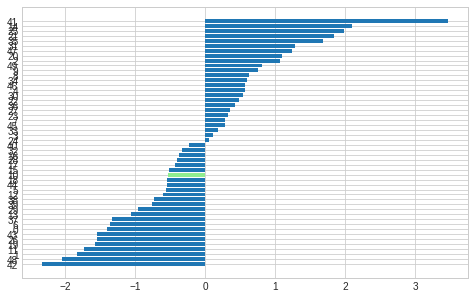

In [6]:
bar(pd.Series(np.random.normal(size=50)), baseline=10, horizontal=True)

## Dataset

In particular, we look at two datasets:

- Ken French's data library (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

- Berkshire Hathaway

In [39]:
%%writefile ../ml4pmt/dataset.py
import requests
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path
from io import BytesIO
import sys
import os
import logging
import re
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import gdown



logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)


def clean_kf_dataframes(df, multi_df=False):
    """
    extract the annual and monthly dataframes from the csv file with specific formatting
    """
    idx = [-2] + list(np.where(df.notna().sum(axis=1) == 0)[0])
    if multi_df:
        cols = ["  Average Value Weighted Returns -- Monthly"] + list(
            df.loc[df.notna().sum(axis=1) == 0].index
        )
    returns_data = {"Annual": {}, "Monthly": {}}
    for i in range(len(idx)):
        if multi_df:
            c_ = (
                cols[i]
                .replace("-- Annual", "")
                .replace("-- Monthly", "")
                .strip()
                .replace("/", " ")
                .replace(" ", "_")
            )
        if i != len(idx) - 1:
            v = df.iloc[idx[i] + 2: idx[i + 1] - 1].astype(float)
            v.index = v.index.str.strip()
            if len(v) != 0:
                if len(v.index[0]) == 6:
                    v.index = pd.to_datetime(v.index, format="%Y%m")
                    if multi_df:
                        returns_data["Monthly"][c_] = v
                    else:
                        returns_data["Monthly"] = v
                    continue
                if len(v.index[0]) == 4:
                    v.index = pd.to_datetime(v.index, format="%Y")
                    if multi_df:
                        returns_data["Annual"][c_] = v
                    else:
                        returns_data["Annual"] = v
    return returns_data


def load_kf_returns(
    filename="12_Industry_Portfolios", cache_dir=None, force_reload=False
):
    """
    load industry returns for Ken French website:
    https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
    """

    if filename == "12_Industry_Portfolios":
        skiprows, multi_df = 11, True
    if filename == "F-F_Research_Data_Factors":
        skiprows, multi_df = 3, False
    if filename == "F-F_Momentum_Factor":
        skiprows, multi_df = 13, False
    if filename == "F-F_Research_Data_Factors_daily":
        skiprows, multi_df = 4, False
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / "data"
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
    output_dir = cache_dir / filename
    if (output_dir.is_dir()) & (~force_reload):
        logger.info(f"logging from cache directory: {output_dir}")
        returns_data = load_dict(output_dir)
    else:
        logger.info("loading from external source")
        path = (
            "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/"
            + filename
            + "_CSV.zip"
        )
        r = requests.get(path)
        files = ZipFile(BytesIO(r.content))

        df = pd.read_csv(files.open(filename + ".CSV"),
                         skiprows=skiprows, index_col=0)
        if 'daily' in filename: 
            returns_data = {'Daily': df.iloc[:-1].pipe(lambda x: x.set_index(pd.to_datetime(x.index)))}            
        else: 
            returns_data = clean_kf_dataframes(df, multi_df=multi_df)


        logger.info(f"saving in cache directory {output_dir}")
        save_dict(returns_data, output_dir)
    return returns_data


def load_buffets_data(cache_dir=None, force_reload=False):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / "data"
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)

    filename = cache_dir / "ffdata_brk13f.parquet"

    if (filename.is_file()) & (~force_reload):
        logger.info(f"logging from cache directory: {filename}")
        df = pd.read_parquet(filename)

    else:
        logger.info("loading from external source")
        path = "https://github.com/slihn/buffetts_alpha_R/archive/master.zip"
        r = requests.get(path)
        files = ZipFile(BytesIO(r.content))

        df = pd.read_csv(
            files.open("buffetts_alpha_R-master/ffdata_brk13f.csv"), index_col=0
        )
        df.index = pd.to_datetime(df.index, format="%m/%d/%Y")
        logger.info(f"saving in cache directory {filename}")
        df.to_parquet(filename)
    return df


symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}


def load_sklearn_stock_returns(cache_dir=None, force_reload=False):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / "data"
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)

    filename = cache_dir / "sklearn_returns.parquet"

    if (filename.is_file()) & (~force_reload):
        logger.info(f"logging from cache directory: {filename}")
        df = pd.read_parquet(filename)

    else:
        logger.info("loading from external source")
        url = "https://raw.githubusercontent.com/scikit-learn/examples-data/master/financial-data"
        df = (
            pd.concat(
                {
                    c: pd.read_csv(f"{url}/{c}.csv", index_col=0, parse_dates=True)[
                        "close"
                    ].diff()
                    for c in symbol_dict.keys()
                },
                axis=1,
            )
            .asfreq("B")
            .iloc[1:]
        )

        logger.info(f"saving in cache directory {filename}")
        df.to_parquet(filename)
    return df


def save_dict(data, output_dir):
    assert isinstance(data, dict)
    if output_dir.is_dir() is False:
        os.mkdir(output_dir)
    for k, v in data.items():
        if isinstance(v, pd.DataFrame):
            v.to_parquet(output_dir / f"{k}.parquet")
        else:
            save_dict(v, output_dir=output_dir / k)


def load_dict(input_dir):
    data = {}
    for o in os.scandir(input_dir):
        if o.name.endswith(".parquet"):
            k = o.name.replace(".parquet", "")
            data[k] = pd.read_parquet(o)
        elif o.is_dir:
            data[o.name] = load_dict(o)
    return data



def get_fomc_urls(from_year = 1999, switch_year=2017): 
    calendar_url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
    r = requests.get(calendar_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    contents = soup.find_all('a', href=re.compile('^/newsevents/pressreleases/monetary\d{8}[ax].htm'))
    urls_ = [content.attrs['href'] for content in contents]

    for year in range(from_year, switch_year):
        yearly_contents = []
        fomc_yearly_url = f'https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm'
        r_year = requests.get(fomc_yearly_url)
        soup_yearly = BeautifulSoup(r_year.text, 'html.parser')
        yearly_contents = soup_yearly.findAll('a', text='Statement')
        for yearly_content in yearly_contents:
            urls_.append(yearly_content.attrs['href'])
    
    urls = ['https://www.federalreserve.gov' + url for url in urls_]
    return urls 

def sent_cleaner(s): 
    return s.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip() 
    
def bs_cleaner(bs, html_tag_blocked=None): 
    if html_tag_blocked is None: 
        html_tag_blocked = ['style', 'script', '[document]',  'meta',  'a',  'span',  'label', 'strong', 'button', 
                     'li', 'h6',  'font', 'h1', 'h2',  'h3', 'h5', 'h4',  'em', 'body', 'head']
    return [sent_cleaner(t) for t in bs.find_all(text=True) 
            if (t.parent.name not in html_tag_blocked)&(len(sent_cleaner(t))>0)]



regexp = re.compile(r'\s+', re.UNICODE)

def feature_extraction(corpus, sent_filters=None):
    if sent_filters is None: 
        sent_filters = ['Board of Governors', 'Federal Reserve System',
                         '20th Street and Constitution Avenue N.W., Washington, DC 20551',
                         'Federal Reserve Board - Federal Reserve issues FOMC statement',
                         'For immediate release',
                         'Federal Reserve Board - FOMC statement',
                         'DO NOT REMOVE:  Wireless Generation',
                         'For media inquiries', 
                         'or call 202-452-2955.',
                         'Voting', 
                         'For release at', 
                         'For immediate release', 
                        'Last Update', 
                        'Last update'
                        ]

    text = [' '.join([regexp.sub(' ', s) for i, s in enumerate(c) 
                     if (i>1) & np.all([q not in s for q in sent_filters])])
            for c in corpus]
    
    release_date = [pd.to_datetime(c[1].replace('Release Date: ', '')) for c in corpus]
    last_update = [pd.to_datetime([s.replace('Last update:', '').replace('Last Update:', '').strip() 
                   for s in c if 'last update: ' in s.lower()][0]) for c in corpus]
    voting = [' '.join([s for s in c if 'Voting' in s]) for c in corpus]
    release_time = [' '.join([s for s in c if ('For release at' in s)|('For immediate release' in s)]) for c in corpus]
    
    return pd.DataFrame({'release_date': release_date, 
                         'last_update':  last_update, 
                         'text': text, 
                         'voting': voting, 
                         'release_time': release_time})

def load_fomc_statements(add_url=True, cache_dir=None, force_reload=False, 
                        progress_bar=True, from_year=1999):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / "data"
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
        
    filename = cache_dir / 'fomc_statements.parquet'
    if (filename.exists()) & (~force_reload):
        logger.info(f"logging from cache file: {filename}")
        statements = pd.read_parquet(filename)
    else: 
        logger.info("loading from external source")
        urls = get_fomc_urls(from_year = from_year)
        if progress_bar: 
            urls_ = tqdm(urls)
        else: 
            urls_ = urls 
        corpus = [bs_cleaner(BeautifulSoup(requests.get(url).text, 'html.parser')) for url in urls_]
        statements = feature_extraction(corpus).set_index('release_date')
        if add_url: 
            statements = statements.assign(url=urls)
        statements= statements.sort_index()
        logger.info(f"saving cache file {filename}")
        statements.to_parquet(filename)
    return statements


def load_fomc_change_date(as_datetime=True): 
    change_up = pd.to_datetime(['1999-06-30', '1999-08-24', '1999-11-16', '2000-02-02',
                                          '2000-03-21', '2000-05-16', '2004-06-30', '2004-08-10',
                                          '2004-09-21', '2004-11-10', '2004-12-14', '2005-02-02',
                                          '2005-03-22', '2005-05-03', '2005-06-30', '2005-08-09',
                                          '2005-09-20', '2005-11-01', '2005-12-13', '2006-01-31',
                                          '2006-03-28', '2006-05-10', '2006-06-29', '2015-12-16',
                                          '2016-12-14', '2017-03-15', '2017-06-14', '2017-12-13',
                                          '2018-03-21', '2018-06-13', '2018-09-26', '2018-12-19',
                                          '2022-03-16', '2022-05-04', '2022-06-15',
                                          '2022-07-27'])

    change_dw = pd.to_datetime(['2001-01-03', '2001-01-31', '2001-03-20', '2001-04-18',
                                          '2001-05-15', '2001-06-27', '2001-08-21', '2001-09-17',
                                          '2001-10-02', '2001-11-06', '2001-12-11', '2002-11-06',
                                          '2003-06-25', '2007-09-18', '2007-10-31', '2007-12-11',
                                          '2008-01-22', '2008-01-30', '2008-03-18', '2008-04-30',
                                          '2008-10-08', '2008-10-29', '2008-12-16',
                                          '2019-07-31', '2019-09-18', '2019-10-30',
                                          '2020-03-03', '2020-03-15'])
    if as_datetime: 
        change_up, change_dw = pd.to_datetime(change_up), pd.to_datetime(change_dw)

    return change_up, change_dw


def load_loughran_mcdonald_dictionary(cache_dir=None, force_reload=False, quiet=True): 
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / "data"
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
        
    filename = cache_dir / 'Loughran-McDonald_MasterDictionary_1993-2021.csv'
    if (filename.exists()) & (~force_reload):
        logger.info(f"logging from cache file: {filename}")
    else: 
        logger.info("loading from external source")
        url = 'https://drive.google.com/uc?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik'
        output = str(filename)
        gdown.download(url, output, quiet=quiet, fuzzy=True)
        
    return pd.read_csv(filename)

Overwriting ../ml4pmt/dataset.py


### Ken French data: industry returns

In [8]:
from ml4pmt.dataset import load_kf_returns, load_sklearn_stock_returns, load_buffets_data

In [9]:
%%time
returns_data = load_kf_returns(
    filename="12_Industry_Portfolios", cache_dir="data", force_reload=True
)

INFO:ml4pmt.dataset:loading from external source
INFO:ml4pmt.dataset:saving in cache directory data/12_Industry_Portfolios
CPU times: user 73.4 ms, sys: 9.76 ms, total: 83.1 ms
Wall time: 731 ms


Reloading from a cache directory is faster!

In [10]:
%%time
returns_data = load_kf_returns(
    filename="12_Industry_Portfolios", cache_dir="data", force_reload=False
)

INFO:ml4pmt.dataset:logging from cache directory: data/12_Industry_Portfolios
CPU times: user 33.9 ms, sys: 6.92 ms, total: 40.8 ms
Wall time: 30.9 ms


In [11]:
returns_data_SMB_HML = load_kf_returns(
    filename="F-F_Research_Data_Factors", cache_dir="data"
)

INFO:ml4pmt.dataset:logging from cache directory: data/F-F_Research_Data_Factors


In [12]:
returns_data_MOM = load_kf_returns(filename="F-F_Momentum_Factor", cache_dir="data")

INFO:ml4pmt.dataset:logging from cache directory: data/F-F_Momentum_Factor


In [13]:
returns_data_DAILY = load_kf_returns(filename="F-F_Research_Data_Factors_daily", force_reload=True)['Daily']

INFO:ml4pmt.dataset:loading from external source
INFO:ml4pmt.dataset:saving in cache directory /home/schamponn/python/sypy/machine-learning-for-portfolio-management-and-trading/nbs/data/F-F_Research_Data_Factors_daily


### Stock returns (2003-2007)

In [14]:
%%time 
returns_data = load_sklearn_stock_returns(cache_dir="data", force_reload=True)

INFO:ml4pmt.dataset:loading from external source
INFO:ml4pmt.dataset:saving in cache directory data/sklearn_returns.parquet
CPU times: user 562 ms, sys: 35.6 ms, total: 598 ms
Wall time: 12.3 s


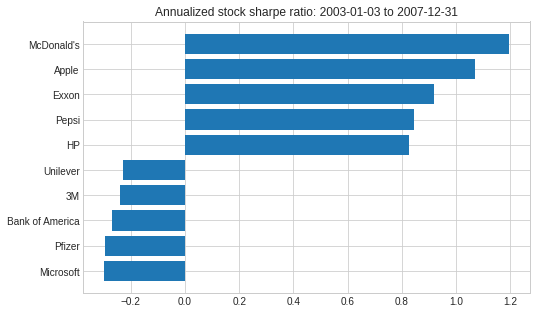

In [15]:
from ml4pmt.metrics import sharpe_ratio
from ml4pmt.dataset import symbol_dict

start_date, end_date = returns_data.index[0].strftime('%Y-%m-%d'), returns_data.index[-1].strftime('%Y-%m-%d')

df = returns_data.pipe(sharpe_ratio).rename(index=symbol_dict).sort_values()\
            .pipe(lambda x: pd.concat([x.head(), x.tail()]))
bar(df, horizontal=True, title=f'Annualized stock sharpe ratio: {start_date} to {end_date}')

### 13F Berkshire Hathaway

In [16]:
%%time 
df = load_buffets_data(cache_dir="data", force_reload=True)

INFO:ml4pmt.dataset:loading from external source
INFO:ml4pmt.dataset:saving in cache directory data/ffdata_brk13f.parquet
CPU times: user 30.5 ms, sys: 2.14 ms, total: 32.6 ms
Wall time: 914 ms


### FOMC Statements 

In [17]:
from ml4pmt.dataset import load_fomc_statements

In [37]:
%%time 
statements = load_fomc_statements(force_reload=True)

INFO:ml4pmt.dataset:loading from external source


  0%|          | 0/203 [00:00<?, ?it/s]

INFO:ml4pmt.dataset:saving cache file /home/schamponn/python/sypy/machine-learning-for-portfolio-management-and-trading/nbs/data/fomc_statements.parquet
CPU times: user 8.57 s, sys: 181 ms, total: 8.75 s
Wall time: 1min 6s


In [20]:
%%time 
statements = load_fomc_statements(force_reload=False)

INFO:ml4pmt.dataset:logging from cache file: /home/schamponn/python/sypy/machine-learning-for-portfolio-management-and-trading/nbs/data/fomc_statements.parquet
CPU times: user 6.88 ms, sys: 2.33 ms, total: 9.22 ms
Wall time: 7.18 ms


### Loughran-McDonalds sentiment dictionary

In [40]:
from ml4pmt.dataset import load_loughran_mcdonald_dictionary

In [41]:
lm = load_loughran_mcdonald_dictionary()

INFO:ml4pmt.dataset:logging from cache file: /home/schamponn/python/sypy/machine-learning-for-portfolio-management-and-trading/nbs/data/Loughran-McDonald_MasterDictionary_1993-2021.csv


### FOMC dates 

In [35]:
from ml4pmt.dataset import load_fomc_change_date
load_fomc_change_date()

(DatetimeIndex(['1999-06-30', '1999-08-24', '1999-11-16', '2000-02-02',
                '2000-03-21', '2000-05-16', '2004-06-30', '2004-08-10',
                '2004-09-21', '2004-11-10', '2004-12-14', '2005-02-02',
                '2005-03-22', '2005-05-03', '2005-06-30', '2005-08-09',
                '2005-09-20', '2005-11-01', '2005-12-13', '2006-01-31',
                '2006-03-28', '2006-05-10', '2006-06-29', '2015-12-16',
                '2016-12-14', '2017-03-15', '2017-06-14', '2017-12-13',
                '2018-03-21', '2018-06-13', '2018-09-26', '2018-12-19',
                '2022-03-16', '2022-05-04', '2022-06-15', '2022-07-27'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2001-01-03', '2001-01-31', '2001-03-20', '2001-04-18',
                '2001-05-15', '2001-06-27', '2001-08-21', '2001-09-17',
                '2001-10-02', '2001-11-06', '2001-12-11', '2002-11-06',
                '2003-06-25', '2007-09-18', '2007-10-31', '2007-12-11',
            

In [38]:
import gdown
gdown.download??